In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import joblib
!pip install xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
df = pd.read_csv('/content/drive/MyDrive/IS353.P12 - Nhóm 4/Bài tập trên lớp/Báo cáo tiến trình/Datasets/after_process_nhom4_data.csv')

In [13]:
ordinal_features = [' khoa', ' hedt', ' chuyennganh2']

df[ordinal_features] = df[ordinal_features].fillna('Unknown')

encoder = OrdinalEncoder()
df_encoded = encoder.fit_transform(df[ordinal_features])

df_encoded = pd.DataFrame(df_encoded, columns=[f"{col}_mahoa" for col in ordinal_features], index=df.index)

df = pd.concat([df, df_encoded], axis=1)

df.drop(columns=ordinal_features, inplace=True)


print(df.head())

                                       mssv  hocky  namhoc  dtbhk  sotchk  \
0  0000AC05XPvAibaEXe9B2tolTZ0JLoBGbkQixQS6    2.0  2021.0   8.28    21.0   
1  0000AC05XPvAibaEXe9B2tolTZ0JLoBGbkQixQS6    1.0  2022.0   7.56    16.0   
2  0001EB57XPvAibaEXe/twT+sf632fUXnsgPGeB4G    2.0  2019.0   9.00    21.0   
3  0001EB57XPvAibaEXe/twT+sf632fUXnsgPGeB4G    1.0  2020.0   9.11    15.0   
4  0001EB57XPvAibaEXe/twT+sf632fUXnsgPGeB4G    2.0  2020.0   8.75    19.0   

        id   namsinh   gioitinh     noisinh      lopsh   khoahoc   tinhtrang  \
0      NaN       NaN        NaN         NaN        NaN       NaN         NaN   
1      NaN       NaN        NaN         NaN        NaN       NaN         NaN   
2  18570.0    2001.0        0.0   'Nghệ An'   TMĐT2019      14.0         1.0   
3  18570.0    2001.0        0.0   'Nghệ An'   TMĐT2019      14.0         1.0   
4  18570.0    2001.0        0.0   'Nghệ An'   TMĐT2019      14.0         1.0   

     diachi_tinhtp Column1  nhom  dtbhk2   khoa_mahoa   

In [14]:
# Xử lý NaN
df = df.fillna(df.median(numeric_only=True))
df = df.fillna(df.mode().iloc[0])

# Chọn biến đầu vào và đầu ra
X = df.drop(columns=['nhom', 'dtbhk', 'id', ' namsinh', 'mssv', ' noisinh', ' diachi_tinhtp', 'Column1', ' lopsh'], errors='ignore')  # Xóa cột không cần thiết
y = df['dtbhk']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Khởi tạo mô hình XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Huấn luyện mô hình
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [16]:
# Khởi tạo mô hình XGBoost
xgb_model = XGBRegressor(random_state=42)

# Định nghĩa phạm vi tìm kiếm cho các tham số
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2]
}

# Sử dụng RandomizedSearchCV để thử một số tổ hợp ngẫu nhiên
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist,
                                   n_iter=10, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)
# In ra các tham số tối ưu
print("Best parameters found: ", random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.9}


In [17]:
# Dự đoán với mô hình tối ưu
y_pred = random_search.best_estimator_.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# tập Test
y_pred = xgb_model.predict(X_test)

# Đánh giá
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

Mean Absolute Error (MAE): 0.8443708453843123
Mean Squared Error (MSE): 1.492483989404443
Root Mean Squared Error (RMSE): 1.221672619568943
R^2 Score: 0.5983095651489847


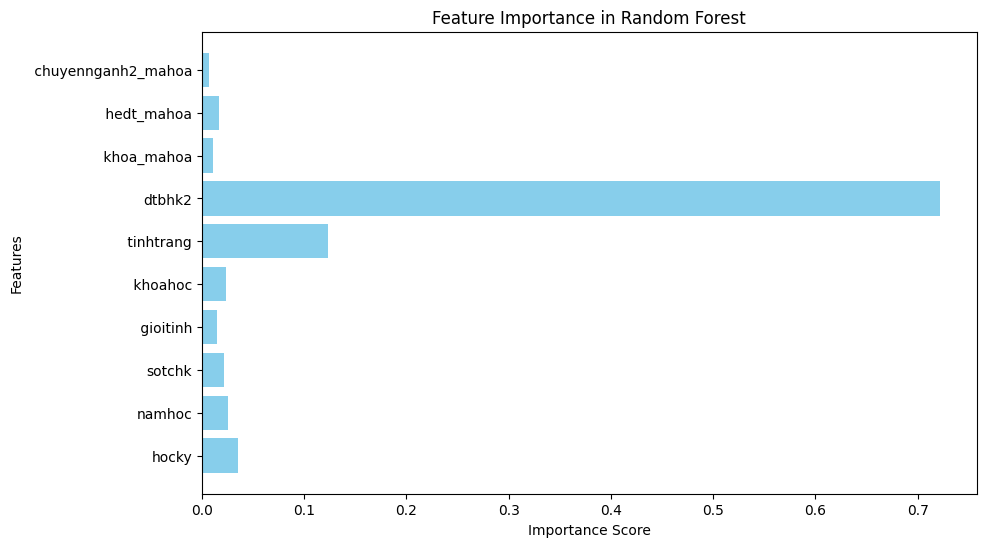

In [ ]:
feature_importances = xgb_model.feature_importances_
features = X.columns


plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, color='skyblue')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.show()

In [ ]:
test_row = pd.DataFrame({
    'hocky': [2.0],
    'namhoc': [2021.0],
    'sotchk': [21.0],
    ' gioitinh': [1.0],
    ' khoahoc': [11.0],
    ' tinhtrang': [1.0],
    'dtbhk2': [5],
    ' khoa_mahoa': [2.0],
    ' hedt_mahoa': [1.0],
    ' chuyennganh2_mahoa': [4.0]
})

In [ ]:
predicted_dtb = xgb_model.predict(test_row)
print(f"Dự đoán DTBHK: {predicted_dtb[0]:.2f}")

Dự đoán DTBHK: 5.23


In [ ]:
joblib.dump(xgb_model, 'xgboost_dtbhk_model.pkl')
# rf_model = joblib.load('random_forest_dtbhk_model.pkl')

['xgboost_dtbhk_model.pkl']